# 【日本語】COVID Global Forecast: SIR model + ML regressions

【はじめに】
日本人の方が始めやすいように、日本語訳や解説を付け加えたものになります。

また、オリジナルサイトは、[Patrick Sánchez](https://www.kaggle.com/saga21)が作成してます。 
オリジナルでは、中国、イタリア、スペイン、イギリス、シンガポールなどの個別考察を行ってますが、これに、日本を加えています
[COVID Global Forecast: SIR model + ML regressions](https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/#data )

【要約】
このNotebookの目的はデータ中心の視点からのCOVID-19（コロナ）送信に関する洞察を、教訓的で簡単な方法で提供することです。
将来の予測をするものではありません。データ探索から得られた観察は個人的な意見です。


【本文】

グローバルなCOVID-19パンデミックの状況において、Kaggleはウイルスに関する未解決の科学的質問のいくつかに答える可能性のある有用な洞察を提供するために、いくつかの課題に取り組みました。 
これは、[COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1)の場合であり、参加者はパンデミックを予測するために世界中のデータに適合させることが推奨されます できれば、COVID-19の感染行動に影響を与える要因を特定するのに役立つと考えられます。


**TABLE OF CONTENTS**

1. [Exploratory data analysis (EDA)](#section1)

    1.1. [COVID-19 global tendency excluding China](#section11)
    
    1.2. [COVID-19 tendency in China](#section12)
    
    1.3. [Italy, Spain, UK and Singapore](#section13)
    
2. [SIR model](#section2)

    2.1. [Implementing the SIR model](#section21)
    
    2.2. [Fit SIR parameters to real data](#section22)
    
3. [Data enrichment](#section3)

    3.1. [Join data, filter dates and clean missings](#section31)
    
    3.2. [Compute lags and trends](#section32)
    
    3.3. [Add country details](#section33)
    
4. [Predictions for the early stages of the transmission](#section4)

    4.1. [Linear Regression for one country](#section41)
    
    4.2. [Linear Regression for all countries (method 1)](#section42)
    
    4.3. [Linear Regression for all countries (method 2)](#section43)
    
    4.4. [Linear regression with lags](#section44)
    
5. [Predictions for the late stages of the transmission](#section5)
    
6. [Statement of the author](#section6)

**注意 **
以下は、[COVID Global Forecast: SIR model + ML regressions](https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/#data )　の免責事項になります。この【日本語版】Notebookの更新予定はありません。

**免責事項1 **：このノートブックは、新しいモデルを使用して予測を改善する目的で頻繁に更新されています。

**免責事項2 **：最新のケースを含めるために、トレーニングデータセットも毎日更新されます。 最新の状態にして、データ漏洩やその他の潜在的な問題を防ぐために、「フィルタリングされた日付」の毎日の更新が適用されます。

**免責事項3 **：COVID Global Forecastingコンテストは毎週更新されます（新しいコンテストとともに）。 ノートブックを前週から新しいノートブックに移動して、最新のコンテストにのみ表示されるようにします。

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1. Exploratory data analysis (EDA) <a id="section1"></a>

まずはデータ構造を確認していきます:

In [ ]:
submission_example = pd.read_csv("../input/covid19-global-forecasting-week-3/submission.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-3/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-3/train.csv")
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train[train['Province_State'].isna()==False]['Country_Region'].unique())

データセットは180か国のデータと、2020年1月22日～2020年4月4日　までの約2か月間のデータになってます。
これは、パンデミックについての手がかりを得るのに十分なデータです。いくつかの洞察を引き出すことができるかどうかを確認するための世界的な傾向のいくつかのプロットを見てみましょう：

In [ ]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**観察**：初期の1月から2月にかけては緩やかに推移しているようですが、これらの数値は発症元国である中国の影響を強く受けています。 COVID-19がそこから始まったことを考えると、この時期の感染した症例に関するデータは、信頼できる情報ではありません。 
実際、感染者のグラフは、2020年02月11日頃に変更され、曲線が強くカーブしていきます。

## 1.1. COVID-19 global tendency excluding China <a id="section11"></a>

最初の発生元の詳細は結果に強く干渉するため、中国を個別に分析することをお勧めします。 
最初に中国なしの結果を見てみましょう：

In [ ]:
#confirmed_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**観察**：<p>
SIRのような典型的な疫学モデルのようです。
SIRは、1927年、生化学者ケルマックと軍医・疫学者マッケンドリックによって、考察された画期的な感染病流行の数理モデルです。
新型の感染症のため免疫を持つ人はいないこと、外部の都市との間で人口移動がないこと、人口は密集し不特定多数の人との接触があること、ペストのような急速かつ短期的な流行を想定したモデルです。

集団を次の3つに分類します。
* 未感染者（Susceptable）
* 感染者（Infected）
* 感染後死亡もしくは回復による免疫を獲得した者（Recovered）

[SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf)
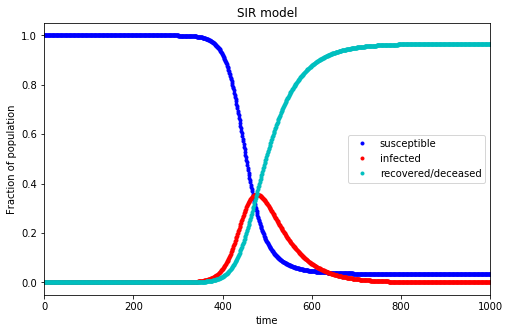
[2. SIR model　SIRシミュレーション](#section2)

## 1.2. COVID-19 tendency in China <a id="section12"></a>

中国が最初の感染国だったため、COVID-19の動作は他の国とは異なります。 医療システムはパンデミックに備えていませんでした。実際、いくつかの症例が報告されるまで誰もウイルスに気づいていませんでした。 さらに、中国政府はかなりの短期間で強力な競合対策を講じ、ウイルスは広く蔓延しているが、感染の増加を抑えることができてます。

In [ ]:
#confirmed_country_China = train[train['Country_Region']=='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_China = train[train['Country_Region']=='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**観察**：<p>
* 滑らかさ・・ 両方のプロットは、理論的なシミュレーションまたは他の世界の累積からの曲線よりも滑らかではありません
* 感染基準・・ 感染事例を検討するための基準が変更された瞬間が直視される
* 不規則性・・ いくつかの不規則性があります。 私は証拠を探すために文献を詳細にチェックする必要がありますが、理由は、流行を監視するために費やされたリソースとotを止めるためのセキュリティ対策の両方が時間とともに変化しているためかもしれません
* プラトー・・ 曲線がプラトーに達しているように見えます。これは中国が最大の感染力にあることを意味します

## 1.3. イタリア, スペイン, イギリス , シンガポール <a id="section13"></a>

ヨーロッパのイタリアとスペインの両方で、COVID-19が大幅に増加しています。 同時に、英国はヨーロッパで最も重要な国の1つですが、最近EUを脱退し、他の国からの人間の移動に対する効果的な障壁が作成されました。 このセクションで調査する4番目の国はシンガポールです。アジアの島であり、中国に近く、その社会経済的条件は他の3つの国とは異なります。

In [ ]:
#confirmed_country_Italy = train[train['Country_Region']=='Italy'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[train['Country_Region']=='Italy'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

日本の場合

In [ ]:
confirmed_total_date_Japan = train[train['Country_Region']=='Japan'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Japan = train[train['Country_Region']=='Japan'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Japan = confirmed_total_date_Japan.join(fatalities_total_date_Japan)

plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
total_date_Japan.plot(ax=plt.gca(), title='Japan')

国の総人口と感染症の相関をみてみましょう。

In [ ]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.5)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.5)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.1)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.05)

日本の場合 （日本の総人口 = 1.26476741億人）


In [ ]:
pop_japan = 126476461.

total_date_Japan.ConfirmedCases = total_date_Japan.ConfirmedCases/pop_japan*100.
total_date_Japan.Fatalities = total_date_Japan.ConfirmedCases/pop_japan*100.

plt.subplot(1, 1, 1)
total_date_Japan.ConfirmedCases.plot(ax=plt.gca(), title='Japan')
plt.ylim(0, 0.006)

最初に確認されたケースからの感染の進展を4カ国（＋日本）で比較してみました。
日本は4か国に比べて、人口比率でみた場合に、ウィルスの進行が遅いです。

In [ ]:
#confirmed_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:70] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:70] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:70] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:70] 

# 日本を追加
japan = [i for i in total_date_Japan.ConfirmedCases['sum'].values]
japan_30 = japan[0:70] 

confirmed_total_date_Japan = train[(train['Country_Region']=='Japan') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Japan = train[(train['Country_Region']=='Japan') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Japan = confirmed_total_date_Japan.join(fatalities_total_date_Japan)

# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.plot(japan_30)
plt.legend(["Italy", "Spain", "UK", "Singapore","Japan"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=20)
plt.ylim(0, 130000)
plt.show()

**Observations**:
* **Italy**. With almost 120.000 confirmed cases, Italy shows one of the most alarming scenarios of COVID-19. The infections curve is very steep, and more than 2% of population has been infected
* **Spain**. Spain has the same number of cumulative infected cases than Italy, near 120.000. However, Spain's total population is lower (around 42 millions) and hence the percentage of population that has been infected rises up to 3%.
* **United Kingdom**. Despite not being very far from them, the UK shows less cases. This may be due to the number of tests performed, but it's  soon to know for sure. The number of cases is around 40.000, this is, a 0.6 of the total population.
* **Singapore**. Singapore is relatively isolated given that is an island, and the number of international travels is lower than for the other 3 countries. The number of cases is still very low (>1000), despite the general tendency is to increase. However, the infections started faster in the beginning, but the slope of the infections curve hasn't increased very much in the past weeks. A 0.2% of the population was infected


**観察**：<p>
* **イタリア**。 120,000を超える症例が確認され、イタリアはCOVID-19の最も憂慮すべきシナリオの1つを示しています。感染曲線は非常に急で、感染した人口の割合は2％近くです

* **スペイン**。スペインの累積感染症例数はイタリアと同じで、120.000近くです。 ただし、スペインの総人口は少なく（約4200万人）、したがって、感染した人口の割合は最大3％に上昇します。

* **イギリス**。それらからそれほど遠くないにもかかわらず、英国はより少ない症例を示しています。これにはいくつかの理論があります。 @codingdonは、COVID-19テストの数が少ない方向を指摘しており、おそらくBrexitプロセスが海外旅行に影響を及ぼし、COVID-19の到着を遅らせたと思いますとにかく、これらは単なる理論であり、当然のこととは言えません。COVID-19によって報告された英国市民の0.004％のみが報告されています感染

* **シンガポール**。シンガポールは島であることから比較的孤立しており、海外旅行の数は他の3か国よりも少ないです。 一般的な傾向が増加する傾向にあるにもかかわらず、症例数は依然として非常に少ない（> 1000）。 ただし、感染は最初は早く始まりましたが、感染曲線の傾きはここ数週間あまり大きくなりませんでした。 人口の0.2％が感染してます。

* **日本**　日本もシンガポールと同じ島で、隣国とは孤立しています。感染は2020年02月13日の初期から始まりましたが、感染曲線の傾きはここ数週間あまり大きくなりませんでした。

# 2. SIR model <a id="section2"></a>
コロナウイルスが発生した国と他の4つ（＋日本）の興味深い国の集計データで、ウイルスのいくつかの一般的な動作を確認しました。
このデータから抽出すべき多くの情報があります。たとえば、私たちは国の緯度/経度の影響を分析できていません。
しかしながら、Notebookの大きな目的は、COVID-19感染に影響を与える主要な要因を探るための予測モデルを開発することになりますので、
ここからは、疫学モデル最も有名な１つのSIRを作っていくことにします。


SIRは、集団を次の3つに分類します。
* 1.未感染者（Susceptable）** 病気にかかっていませんが、感染者からの接触により感染する可能性があります
* 2.感染者（Infected） ** 感染にかかっている人
* 3.感染後死亡もしくは回復による免疫を獲得した者（Recovered/deceased）** この状態の人は、他の人に感染症を移すことはありません。これ以上感染を移さないという意味のため、感染により死亡した方も含みます。

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)


このモデルには、出生と死亡（人口統計学を伴うSIRD）、中間状態などを考慮した多くのバージョンがあります。
ただし、COVID-19拡張の初期段階にあり、短期的に関心が集まっているため、 人々は免疫を発達させ（長期的には免疫が失われ、COVID-19が一般的なインフルエンザのような特定の季節内に再発する可能性があります）、回復した状態から残りの2つの状態に移行しないと見なします。 

これにより、システムを支配する微分方程式は次のようになります。
$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where $\beta$ is the contagion rate of the pathogen and $\gamma$ is the recovery rate.

## 2.1. Implementing the SIR model <a id="section21"></a>

SIRモデルは多くの方法で実装できます。システムを支配する微分方程式から、平均場近似内でまたはソーシャルネットワークでダイナミクスを実行します（グラフ）。 簡単にするために、最初のオプションを選択しました。ここでは、ルンゲ＝クッタ法（Runge-Kutta）を実行して微分方程式システムを解くだけです。

dif.eqs関数は、 次のとおりです。

In [ ]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

微分方程式系を解くために、 [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) を用います。方法:

In [ ]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

最後に、感染症の進行具体を知るために、単に初期条件をrk4で定義します method:

In [ ]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

N =世界の人口、最初の感染症例は1つだけです, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ :

In [ ]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

**観察**：<p>
-感染者　I（infected）は一定期間増加していきますが、時間とともに感染に対する免疫がつき 回復 R(recover/decease）が増えてきます。
 そのため、最終的に感染者　I（infected）は減少していきます。
 
-感染者　I（infected）が増えてくると、感染症への免疫がない人（Susceptible）は減少していき、最終的に0に近い状態になります。
    
-回復 R(recover/decease）の場合は、反対のことが起こります

異なる初期条件とパラメーター値が他のシナリオにつながることに注意してください。システムを研究するためにこれらの数値を自由に試してください。

## 2.2. SRIパラメーターを実際のケースに当てはめる <a id="section22"></a>
SIRモデルは理論的なものであり、ウイルスの伝染を理解するためのものです。COVID-19展開の実際の近似値に近いものを考えてみます。
そのため、システムの進化を予測できるようにする場合は、各ケースの$\beta$ and $\gamma$パラメータを抽出する必要があります。

In [ ]:
population = float(46750238)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

実際のデータが青●になります、オレンジのラインが。予測モデルになります。

**パラメータの適合に満足していません**。
実データと予測データがぴったり一致してません。 
好奇心のためにこれからも作業を続けますが、一旦は予測に対するデータ中心のアプローチを進めていきましょう。

# 3. データ結合や欠損値の処理（データエンリッチメント） <a id="section3"></a>

SIRシミュレーションの分析は、COVID-19を含む多くのウイルスの感染メカニズムにほぼ似たモデルを理解することを目的としていました。
しかし、パンデミックの進展を予測し、理解するためにも同様に有用であると証明できる別の方法があります。 これらの方法の多くは、豊富なデータを使用して結論を抽出し、アルゴリズムがデータのパターンを推定できるようにします。これがまさに私たちがやろうとしていることです。

*このセクションの主なワークフロー：
1.データを結合し、日付をフィルタリングし、欠落を消去します
2.ラグとトレンドを計算する
3.国の詳細を追加する


**免責事項**:
このデータ強化は必須ではなく、モデルのすべての新機能を使用しない可能性があります。 ただし、たとえば綿密な探索的分析では、確かに何らかの価値を追加する教訓的なステップだと思います。

## 3.1. データの結合、日付と欠損値の処理 <a id="section31"></a>

First of all, we perform some pre-processing prepare the dataset, consisting on:

まず、データセットを準備する前処理を実行します。
* データ結合・・トレーニング/テストに参加してデータ変換を促進する
* フィルター日付 ・・チャレンジ条件に従って、2020-03-12の後に確認済みのケースと死亡者を削除します。 追加の日付列を作成する
* 欠損値・・欠損値を分析して修正する

In [ ]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-26', 'ConfirmedCases'] = 0
all_data.loc[all_data['Date'] >= '2020-03-26', 'Fatalities'] = 0
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-26'])

**観察**：<p>
-「ConfirmedCases」と「Fatalities」は、2020年03月12日より前の日付のデータセットになりました。<p>
-データセットにはすべての国と日付が含まれ、次の処理のラグ/トレンドステップに使います。<p>
-「ConfirmedCases」と「Fatalities」の欠損値は0に置き換えられました。これは、プロセスの最後に覚えていないと危険な場合があります。 ただし、2020-03月12日より前の日付のみをトレーニングするため、これは予測アルゴリズムに影響しません
-最初の日付から始まる日カウンターとして、新しい列「日」が作成されました<p>

欠落している値が残っていないことを再確認します。

In [ ]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

## 3.2. Compute ラグ特徴量 and trends <a id="section32"></a>

良い結果を得るには、データセットを充実させることが重要です。 


この場合、2つの異なる変換を適用します。

**Lag**. ラグ(Lag)は、列の以前の値を計算する方法です。そのため、ConfirmedCasesのラグ1(Lag1)は、前日からこの列に追加します。 要素Xのラグ3は次のとおりです。なぜこのようにするかというと、現時点のデータ1点で予測するより、過去データを活用した方が予測精度が向上する場合があるためです。

今回は、以下のように定義します
$$X_{lag3}(t) = X(t-3)$$

**Trend**. 時系列のデータは、トレンド性を考慮すると自然になります。　他にも時系列データとして、月周期性、年周期性、週周期性、季節性を考慮するとうまくいくかもしれません。

今回、適用する定義は次のとおりです。
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

適用するラグのバックログは14日ですが、トレンドの場合は7日です。 ConfirmedCasesとFatalitiesの場合：

In [ ]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

スペインのラグ処理は高速になりました。

In [ ]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

## 3.3. 国の詳細データを加える <a id="section33"></a>

国の総人口、市民の平均年齢、都市に住んでいる人の割合などの変数は、COVID-19の伝送動作に大きな影響を与える可能性があります。 したがって、これらの要因を考慮することが重要です。 私はこの目的のためにWebスクラッピングに基づく[Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020)を使ってます。

In [ ]:
# Load countries data file
world_population = pd.read_csv("/kaggle/input/population-by-country-2020/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

[Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020)を引用した結果、Country (or dependency)　→Province_State　に変更されてます。例えば、japanはProvince_State	は、11となります。

# 4. 感染の初期段階の予測 <a id="section4"></a>

このセクションの目的は、他の回帰問題と同様に、データ中心の観点から拡張の進化を予測することです。 最終的な提出には2020年03月12日以降のデータのみ含めません。

Models to apply:
1. Linear Regression for one country　
2. Linear Regression for all countries (method 1)
3. Linear Regression for all countries (method 2)

## 4.1. Linear Regression（線形回帰）を１つの国だけに適用する  <a id="section41"></a>

私たちはパンデミックの将来の時間発展を予測したいので、最初のアプローチは単純なLinear Regression（線形回帰）を使います。 ただし実際は線形ではなく指数関数的であることを思い出してください。（感染の開始時を分析したいために、Linear Regression（線形回帰）を適当しているだけです）そのため、事前の対数変換が必要です。

日本の両方のケースを視覚的に比較し、3月1日以降の過去10日間のデータを取得します。

日本の場合

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Japan']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Japan ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Japan']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Japan Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

対数変換の結果は、直線回帰のような素晴らしい直線になります。 
ただし、2つの重要な点を明確にしましょう。

*この「ほぼ指数関数的な振る舞い」は、パンデミックの初期感染段階（SIRモデルでの感染の初期増加）にのみ当てはまりますが、ほとんどの国の現時点のデータです。

*過去10日間のデータのみを抽出するのはなぜですか？ 3つの理由があります。
1. 進化の非常に短期的な要素を正確に捉えるため
2. 送信速度に影響を与えてきた特定の変数の影響を防ぐため（隔離と自由循環）
3. 症例を確認する際の基準の違いを防ぐため（中国プロットの奇妙な傾斜を覚えていますか？）

今回適用した線形回帰モデル(Linear Regression)は、非常に単純であり、要素の特徴のみが考慮されます
例えば、国/地域、日付情報、緯度/経度。ラグ、トレンド、国の詳細などのデータは、入力として導入されていません。

基本的な、線形回帰モデルのワークフローは次のとおりです。
1. 要素　・・データに必要な要素を抽出します
2. 日付　・・ 2020年03月01日から2020年03月18日までのtrainデータをフィルタリングする
2. ログ変換　・・　 ConfirmedCasesとFatalitiesにログ変換を適用する
3. 無限　・・　対数の無限大を0に置き換えます。log（0）の対数の漸近的な動作を考えると、これは逆変換（指数）を適用すると0ではなく1が返されることを意味します。この問題は多くの国に影響を与えません、ただし、クリーンなソリューションを取得するには、遅かれ早かれ取り組む必要があります。
4. トレーニング/テスト分割　・・ train/valid/testへの分割
5. 予測　・・　線形回帰、国ごとのトレーニングおよび参加データ
6. サブミット　・・　結果を正しい形式で送信し、指数を逆対数変換に適用する

In [ ]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    # Train set
    x_train = df[df.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = df[df.ForecastId == -1]['ConfirmedCases']
    y_train_2 = df[df.ForecastId == -1]['Fatalities']

    # Test set
    x_test = df[df.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

他の国でも試してみましょう。

* **スペイン**

In [ ]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03']

In [ ]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][50:70]

In [ ]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    X_final_check = pd.concat([X_train_check, X_test_check])

    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(24-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(24-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
    
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 63, 106
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **イタリア**

In [ ]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **ドイツ**

In [ ]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **アルバニア**

In [ ]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **アンドラ**

In [ ]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 10
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

In [ ]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 21
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

**Observations**:

* The general evolution is captured despite the simplicity of the model
* The cumulative infected cases has been changing in March, so that using thw whole month data for training results in overestimated predictions. When reducing the training set to only a few days prior the testing region, results are better. This is capturing the problem of the exponential behavior, that is only true for the early stages of the spreading. Now the behavior is more complex, and in order to predict the evolution with large portions of the historic evolution, alternative models are required (sigmoid, ARIMA...)
* Estimations are increasingly worse as time passes (harder to extrapolate)
* Countries that recently confirmed their first contagions are difficult to predict (less data points) 
* Countries with 0 cases in the whole training dataset are predicted as non-infected (no datapoints)

** Questions to tackle in next subsections**:
* How to obtain the full submission set? 
* What to do for countries with different Provinces/State informed?
* Is there any alternative to manually setting the size of the train data? 


**観察**：
*モデルのシンプルさにもかかわらず、一般的な進化が捉えられている
*累積感染例は3月に変化しているため、トレーニングに月全体のデータを使用すると、予測が過大になります。トレーニングセットをテスト領域の数日前のみに減らすと、結果はより良くなります。これは、指数関数的な動作の問題を捉えています。これは、拡散の初期段階にのみ当てはまります。これで動作がより複雑になり、歴史的な進化の大部分を伴う進化を予測するには、代替モデルが必要になります（シグモイド、ARIMA ...）
*推定値は時間の経過とともにますます悪化します（推定が難しくなります）。
*最近最初の感染を確認した国は予測が困難です（データポイントが少ない）
*トレーニングデータセット全体でケースが0である国は、感染していないと予測されます（データポイントなし）

**次のサブセクションで取り組む質問**：
*完全な提出セットの入手方法は？
*異なる州/州に通知された国に対して何をすべきか？
*トレーニングデータのサイズを手動で設定する以外の方法はありますか？

## 4.2 Linear Regression for all countries (method 1) <a id="section42"></a>

一つ目の方法は、10個の履歴データポイントのみでフィッティングすると、Linear Regressionのパフォーマンスに影響を与えるいくつかの問題のあるシナリオが表示されることです。 すべての国でモデルを一般化して、避けられない問題かどうかを確認してみましょう。 すべての国で実行する手順：

* 1.国ごとにループ
* 2.州リストを計算する
* 3.州がある場合は、それぞれに Linear Regressorを実行します
* 4.それ以外の場合、 Linear Regressorを実行する

In [ ]:
ts = time.time()

def linreg_basic_all_countries(data, day_start, train_lim, test_lim):
    
    data2 = data.loc[data.Day_num >= day_start]

    # Set the dataframe where we will update the predictions
    data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    print("Currently running Linear Regression for all countries")

    # Main loop for countries
    for c in data2['Country_Region'].unique():

        # List of provinces
        provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()

        # If the country has several Province/State informed
        if len(provinces_list)>1:
            for p in provinces_list:
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

        # No Province/State informed
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

    # Apply exponential transf. and clean potential infinites due to final numerical precision
    data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
    data_pred.replace([np.inf, -np.inf], 0, inplace=True) 
    
    return data_pred


day_start = 60
data_pred = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) 
2週目、2020-03-19より前のトレーニングデータと2020-04-01の測定値：

**1.19681**

## 4.3 Linear Regression for all countries (method 2) <a id="section43"></a>

トレーニングデータの日数を設定する、他の方法として、最初のケースが確認されてから、各国のすべてのデータを保持する方法があります。 
ただし、特定の国では最初の発生が非常にスムーズであったため（例えば、スペインでは確認された症例が7日間続けて1つしかなかったため）、これらの初期期間によって予測が偏る可能性があります。

In [ ]:
ts = time.time()

# Set the dataframe where we will update the predictions
data2 = data.loc[data.Day_num >= day_start]
data_pred3 = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred3['Predicted_ConfirmedCases'] = [0]*len(data_pred3)
data_pred3['Predicted_Fatalities'] = [0]*len(data_pred3)
how_many_days = test.Date.nunique()
    
print("Currently running Linear Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
data_pred3.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(data_pred3, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

経験から、このアプローチは線形回帰モデルには適していません。 多くの場合、最初に強い移行期間があり、偏りが起こりえます。 したがって、以下のセクションではこの方法を適用しませんが、他の目的で使用することは大歓迎です。

Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01: 

**1.62190**

## 4.4. Linear regression（線形回帰）にラグを考慮する <a id="section44"></a>

これらの結果から、線形回帰（Linear regression）はCOVID-19データの初期段階に適したアプローチであると私は確信しています。もちろん、これは私たちが分析している最初の発生にのみ当てはまり、新しい感染の数が減少する時期をモデルが予測することはできません。しかし、短期的な予測の目的では、すべてが順調であり、結果を改善しようと努めています。

以前にいくつかのセクションを計算したラグ変数を覚えていますか？今こそそれらを使用する時ですが、最初に解決するべき問題があります。データセットを使用して次の感染日を予測する場合、最初の日についてはすべてのラグが（前日から）報告されますが、次の日についてはどうですか？ ** ConfirmedCasesの数はトレインサブセットについてのみ既知であるため、**ラグの多くは不明です**（0としてフラグが立てられます）。これを克服する最も簡単な方法は次のとおりです。

ステップ1.すべてのケースとラグが報告されたトレインデータセットから始めます
ステップ2.線形回帰（Linear regression）により、翌日のみを予測
ステップ3.新しい予測を確認済みのケースとして設定します
ステップ4.ラグを再計算する
ステップ5.残りのすべての日について、ステップ2からステップ4を繰り返します。

これらの新しい機能を備えたモデルの動作を分析するために、単一の国でトレーニングを開始します。

In [ ]:
# New split function, for one forecast day
def split_data_one_day(df, d, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    #Train
    x_train = df[df.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = df[df.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + "))")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

* **Spain**

In [ ]:
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data



# Run the model for Spain
country_name = 'Spain'
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Italy**

In [ ]:
ts = time.time()

# Inputs
country_name = "Italy"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Germany**

In [ ]:
# Inputs
country_name = "Germany"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Albania**

In [ ]:
# Inputs
country_name = "Albania"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 7

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Andorra**

In [ ]:
# Inputs
country_name = "Andorra"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 1

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

日本

In [ ]:
# Inputs
country_name = "Japan"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 1

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

**観察**：
* **パラメーター**。 2週間のトレーニングを使用（2月26日から3月11日まで）、過去30ラグ
* **十分なデータ**。 （スペイン、イタリア、ドイツ）。 （3月11日以前の）トレインデータセットに複数のConfirmedCases！= 0がある国の場合、予測は非常に正確で、実際の確認済みデータに類似しています。
* **不十分なデータ**。 （アルジェリア、アンドラ）。 列車データセット内のデータポイントの数が少ない国では、潜在的に悲惨な予測が示されます。 ケースの数が少ない場合、線形変換が続く対数変換では、将来の動作をキャプチャできません
* **データなし**。 トレインデータセットで確認された症例数が0または無視できる場合、モデルは常に感染がないと予測します

各国を毎日トレーニングするためのラグを使用してモデルを一般化しましょう：

In [ ]:
# Inputs
day_start = 39 
lag_size = 30

train3 = train.copy()
train3.Province_State.fillna("None", inplace=True)

results_df = pd.DataFrame()

tp = time.time()

# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
            pred_province = lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim)
            results_df = pd.concat([results_df, pred_province])

    else:
        pred_country = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
        results_df = pd.concat([results_df, pred_country])
        
results_df_submit = results_df.copy()
results_df_submit['ConfirmedCases'] = results_df_submit['ConfirmedCases'].apply(lambda x: np.expm1(x))
results_df_submit['Fatalities'] = results_df_submit['Fatalities'].apply(lambda x: np.expm1(x))
        
#get_submission(results_df_submit.loc[results_df_submit['ForecastId']!=-1], 'ConfirmedCases', 'Fatalities')
print("Complete process finished in ", time.time()-tp)

すべての国と日にモデルを拡張するのは簡単ですが、注意が必要な部分に対処する必要があります。 特定の国の結果を分析したときに見たように、一部の国では0とは異なるトレーニングデータポイントが少なすぎます。これらのシナリオは、現実と乖離した予測回帰アルゴリズムで終わる場合があります。

この問題を克服するための私の提案は、現在の結果と[section 4.2.](#section42)の結果を混合することで構成されています。 トレーニングデータセットで確認された症例が少なすぎるすべての国は、セクション4.2の結果で予測されます。

In [ ]:
results_df_2 = results_df.copy()

day_start = 39
data_pred2 = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
day_num_test = 57    # Day 2020-04-18


# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()

    # Countries with several Province_State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
        
            tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Province_State']==province_dict[province_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

            # When there is not enough data
            if len(tmp_index) < 30:
                
                # ConfirmedCases
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
                
                #Fatalities
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
                
    # Countries without Province_State
    else:
        tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

        # When there is not enough data
        if len(tmp_index) < 30:
            
            #Confirmed Cases
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
            
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
            
results_df_2 = results_df_2.loc[results_df_2['Day_num']>=day_num_test]
#results_df_2[['ConfirmedCases', 'Fatalities']] = results_df_2[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.expm1(x))
#get_submission(results_df_2, 'ConfirmedCases', 'Fatalities')

## 5. 感染後期の予測 <a id="section5"></a>

作成中。。。

## 6.著者声明 <a id="section6"></a>
* **このノートブックの目的**は、データ中心の視点からのCOVID-19送信に関する洞察を、教訓的で簡単な方法で提供することです。予測された結果は、**将来何が起こるかを確認するものではありません**。データ探索から得られた観察は個人的な意見です。


*伝染病の拡大に特化したモデル（SIRとそのバージョンなど）は、伝染過程の根本的なメカニズムを理解するために、特定の現象論を再現するように設計されています。一方、私が使用した単純な機械学習アプローチは、現在の体制における感染の短期的な進展を予測することを目的としています。最終的には、モデルのフィッティングにとって特に重要ないくつかの機能またはパラメーターを見つけるのに役立つ可能性がありますが、決して科学的流行モデルと混同してはなりません。


*現在の予測が成功するかどうかは、**現在の拡散レジームに強く依存**しており、感染症の数は依然として多くの国で指数関数的に増加しています。しかしながら、彼らは最大の伝染ピークに到達するであろう信頼できる期待される日を提供することができない。流行モデルはそのような推定値に近づきますが、これについて考慮する必要がある変数が多数あります（検疫、配備されている医療リソースの品質、環境対策など）。


*このような結果を達成するには、かなりの量の**調整が必要**です。フィッティングステップで使用する必要がある以前の日付の数、ラグを使用するかどうかをフィルターします。また、欠落した置換でさえ、ログ変換により非常に粗くなりました。


* **予測モデル**はいくつかの目的に使用できますが、**決してエキスパートからの推奨として**使用しないでください（お試しレベル**）。

In [ ]:
# ALTERNATIVE FUNCTIONS FOR FURTHER ANALYSIS

# LGB Regressor 
"""
model=lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        #min_child_weight=300,
        #num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=16,
        #reg_alpha=0.04,
        #reg_lambda=0.073,
        #min_split_gain=0.0222415,
        verbose=1,
        seed=21)

model.fit(X_train, Y_train_1, eval_metric="rmse", eval_set=[(X_train, Y_train_1), (X_valid, Y_valid_1)], verbose=1, early_stopping_rounds = 20)

Y_test = model.predict(X_test)
"""


# Show Spain enriched data
"""
data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']==49)]
train[(train['Country/Region']=='Spain') & (train['Date']=='2020-03-12')]
data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']==49)]['ConfirmedCases'].apply(lambda x: np.exp(x))
"""


# XGB Regressor
"""
reg = xgb.XGBRegressor()
reg.fit(X_train, Y_train_1,
        eval_set=[(X_train, Y_train_1), (X_valid, Y_valid_1)],
        early_stopping_rounds=50,
       verbose=True)

_ = plot_importance(reg, height=0.9, max_num_features=20)
Y_pred = reg.predict(X_valid)
print(Y_pred)
"""


# XGB GridSearch
"""
ts = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.07, .01, .005], #so called `eta` value
              'max_depth': [4, 5, 6, 7],
              'min_child_weight': [4, 5, 6, 7],
              'silent': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, Y_train_1)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Y_pred = xgb_grid.predict(X_valid)
print(Y_pred, Y_valid_1)

print("Time spent: ", ts-time.time())
"""


# Some plots
"""
plt.plot(data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']<=49)]['ConfirmedCases'])

y = data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']> 35) & (data['Day']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x = range(0, len(y))
plt.plot(x, y, 'go--')
"""


# Linear Regression
"""
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train_1)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Compute mean squared error on real values (inverse transform of log)
#rms = mean_squared_error(Y_test_1.apply(lambda x: np.exp(x)).astype('int16'), np.exp(y_pred).astype('int16'))
#print("Mean squared error: ", rms)
"""

# LGB 2
"""
def lgb_reg(X_train, Y_train_1, X_test):
    # Create linear regression object
    regr = lgb.LGBMRegressor(n_estimators=1000)

    # Train the model using the training sets
    regr.fit(X_train, Y_train_1, eval_metric="rmse")

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred
"""


# Predictions
"""
#Predictions
X_test_compare = X_test.copy()
X_test_compare['PredictedCases'] = y_pred_xgb
X_test_compare.loc[(X_test_compare['Day']>=50) & (X_test_compare['Day']<73)]

# Train test
compare = train.loc[train['Date'].isin(dates_overlap)]
compare = compare.merge(test[['Country/Region', 'Date', 'ForecastId']], on=['Country/Region', 'Date'])
#compare['PredictedCases'] = X_test_compare.loc[(X_test_compare['Day']>=50) & (X_test_compare['Day']<73), 'PredictedCases']
compare

# Total comparison
total_compare = X_test_compare.join(compare, on='ForecastId', rsuffix='X_compare')
total_compare[['ForecastId', 'Country/Region', 'ConfirmedCases', 'PredictedCases']]
"""


# More plots for LinReg (all countries)
"""
# Select predictions from March 1st to March 22nd

predicted_data = data_pred.loc[(data_pred['Country/Region']==1)].Predicted_ConfirmedCases[:11]

dates_list = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22']
real_data = train.loc[(train['Country/Region']=='Albania') & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, predicted_data)
ax1.plot(dates_list_num, real_data)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, np.log(predicted_data))
ax2.plot(dates_list_num, np.log(real_data))
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")
"""

# ARIMA
"""
# definir conjunto de datos
x = df_mon_to_fri

# instanciar modelo
sarima_model = SARIMAX(x, order=(2,0,1), seasonal_order=(2, 1, 0, 24))

# ajustar modelo
results = sarima_model.fit()

# mirar el AIC
results.aic
"""